## Setup and Import Libraries

In [2]:
import os
import time
import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from deepface import DeepFace
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from utils import Utils

import warnings
warnings.filterwarnings('ignore')

In [3]:
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

### Load the Dataset

#!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

#!unzip -q family_photos.zip

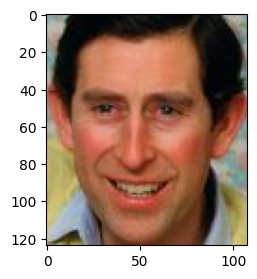

In [4]:
def show_img(f):
    img = plt.imread(f)
    plt.figure(figsize=(4,3))
    plt.imshow(img)

show_img('data/family/dad/P06260_face5.jpg')

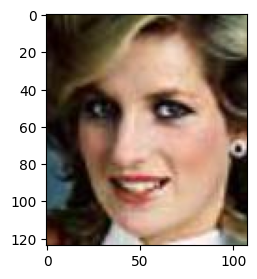

In [5]:
show_img('data/family/mom/P04407_face2.jpg')

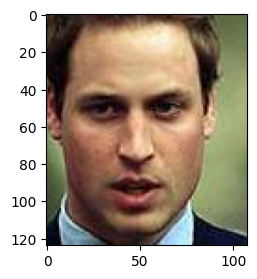

In [6]:
show_img('data/family/child/P04414_face1.jpg')

## Setup Pinecone 

In [7]:
MODEL = "Facenet"
INDEX_NAME = utils.create_index_name('t-ind')

pinecone = Pinecone(api_key=PINECONE_API_KEY)

## Create Embeddings Using DeepFace

In [8]:
def generate_vectors():
  VECTOR_FILE = "./vectors.vec"

  with contextlib.suppress(FileNotFoundError):
      os.remove(VECTOR_FILE)
  with open(VECTOR_FILE, "w") as f:
      for person in ["mom", "dad", "child"]:
          files = glob.glob(f'data/family/{person}/*')
          for file in tqdm(files):
              try:
                  embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
                  f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
              except (ValueError, UnboundLocalError, AttributeError) as e:
                  print(e)

generate_vectors()

100%|██████████| 93/93 [00:07<00:00, 13.08it/s]


In [9]:
with open("vectors.vec", "r", encoding="utf-8") as file:
    for i in range(10):
        print(file.readline().strip())

mom:P04407_face2.jpg:[0.3554881811141968, 1.9981268644332886, 0.31048983335494995, -2.285693407058716, -0.9325134754180908, -0.13315245509147644, 1.6392054557800293, 1.8118747472763062, 0.8850472569465637, 0.03256191685795784, 1.6462103128433228, -1.0044499635696411, -0.4644761085510254, -1.4243513345718384, -0.11943233013153076, -0.04649027809500694, 0.39943715929985046, 0.3761640191078186, 0.48768267035484314, -2.376871109008789, -0.7358355522155762, -1.3787002563476562, 0.09800908714532852, 1.1166187524795532, -1.4406358003616333, 0.6327051520347595, -0.042139194905757904, -0.6839017271995544, -0.7861601114273071, 1.9692615270614624, 0.10219687223434448, -0.801300048828125, 0.8595357537269592, -0.7503849864006042, 1.1273852586746216, -1.5675203800201416, 0.7872260808944702, 2.234508752822876, -0.0677957683801651, 1.467103123664856, -0.9959214329719543, -1.9735864400863647, -0.4187828600406647, 0.5735581517219543, -0.04854266345500946, 0.7179235816001892, 1.2637317180633545, -0.53817

## Plot the Data of Images

In [10]:
def gen_tsne_df(person, perplexity):
    vectors =[]
    with open('./vectors.vec', 'r') as f:
        for line in tqdm(f):
            p, orig_img, v = line.split(':')
            if person == p:
                vectors.append(eval(v))
    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state = 0, n_iter=1000,
                verbose=0, metric='euclidean', learning_rate=75
    )
    
    print(f'transform {len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    
    return pd.DataFrame({'x':embeddings2d[:,0], 'y':embeddings2d[:,1]})

In [11]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

241it [00:00, 12144.84it/s]


transform 70 vectors


241it [00:00, 9162.27it/s]


transform 93 vectors


241it [00:00, 10670.16it/s]


transform 78 vectors


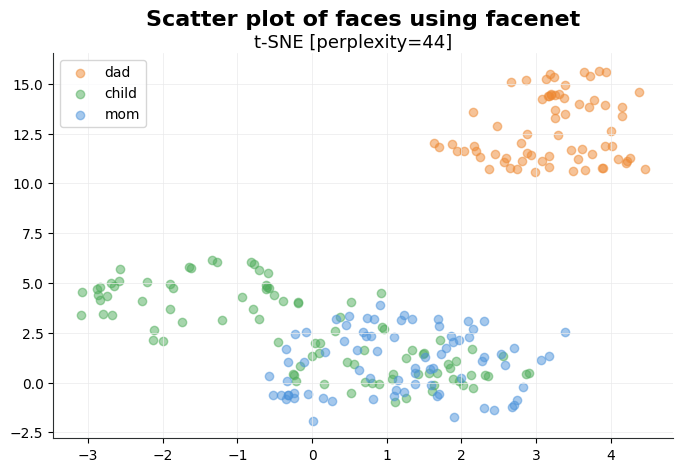

In [12]:
plot_tsne(44, 'facenet')

241it [00:00, 13100.41it/s]


transform 70 vectors


241it [00:00, 8230.49it/s]


transform 93 vectors


241it [00:00, 9924.08it/s]


transform 78 vectors


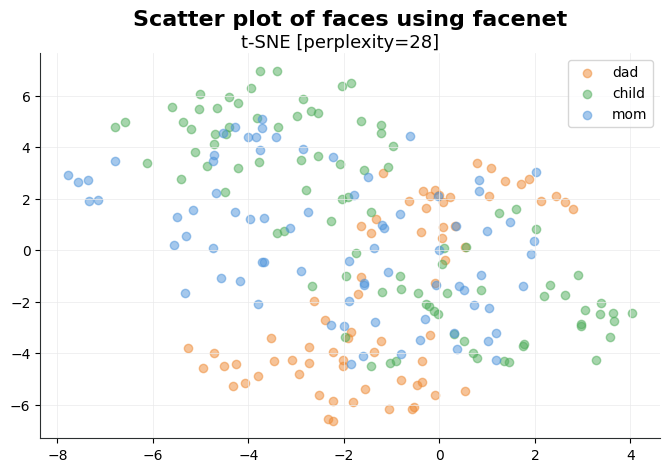

In [13]:
plot_tsne(28, 'facenet')

## Store the Embeddings in Pinecone

In [14]:
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    pinecone.delete_index(INDEX_NAME)

pinecone.create_index(
    name=INDEX_NAME, dimension=128, metric='cosine',
    spec=ServerlessSpec(cloud='aws', region='us-east-1')
)

index = pinecone.Index(INDEX_NAME)

In [15]:
def store_vectors():
    with open("vectors.vec", "r") as f:
        for line in tqdm(f):
            person, file, vec = line.split(':')
            index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])

store_vectors()

241it [01:11,  3.36it/s]


In [16]:
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 241}},
 'total_vector_count': 241}

## Calculate the Similarity Scores

In [17]:
def test(vec_groups, parent, child):
    index = pinecone.Index(INDEX_NAME)
    parent_vecs = vec_groups[parent]
    K = 10
    SAMPLE_SIZE = 10
    sum = 0
    for i in tqdm(range(0,SAMPLE_SIZE)):
        query_response = index.query(
            top_k=K,
            vector = parent_vecs[i],
            filter={
                "person": {"$eq": child}
            }
        )
        
    for row in query_response["matches"]:
        sum  = sum + row["score"]
        
    print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

In [18]:
def compute_scores():
    index = pinecone.Index(INDEX_NAME)
    vec_groups = {"dad":[], "mom":[], "child":[]}
    with open("vectors.vec", "r") as f:
        for line in tqdm(f):
            person, file, vec = line.split(':')
            vec_groups[person].append(eval(vec))
    
    print(f"DAD {'-' * 20}")
    test(vec_groups, "dad", "child")
    
    print(f"MOM {'-' * 20}")
    test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 3954.44it/s]


DAD --------------------


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]




dad AVG: 0.06815681042999999
MOM --------------------


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]



mom AVG: 0.041978084740000005


## Check the Matching Images

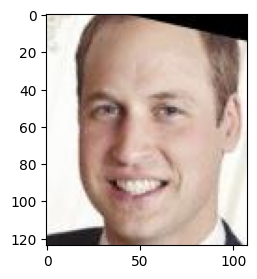

In [19]:
child_base = 'data/family/child/P06310_face1.jpg'
show_img(child_base)

In [20]:
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
print(embedding)

[0.5283992290496826, 1.286186695098877, -0.35614535212516785, -1.0126641988754272, 0.9982877969741821, 0.6666168570518494, 0.5679231286048889, 1.6064088344573975, 0.14698269963264465, -0.5307538509368896, 0.33921492099761963, -1.085303783416748, -0.7407276034355164, -1.2022430896759033, -0.24404263496398926, -0.43662047386169434, -1.6220453977584839, -2.924757480621338, -0.3545488119125366, -0.24917644262313843, 0.030636444687843323, -0.2142239362001419, -0.44208014011383057, -0.318031370639801, -0.4128810465335846, -0.32468870282173157, 1.1288130283355713, 0.4614981412887573, -0.8908520936965942, 0.5013214349746704, -1.8914427757263184, -0.10036158561706543, -2.0040078163146973, -0.5636594891548157, 0.4059147536754608, -0.5800116658210754, -1.5189834833145142, -1.6227530241012573, 1.5995080471038818, -0.3009594976902008, -0.9496628642082214, -1.9736119508743286, -2.546036720275879, -0.24491269886493683, 1.7347679138183594, -1.6264350414276123, 1.3015141487121582, 0.9842956066131592, 0

In [22]:
query_response = index.query(
    top_k=3,
    vector = embedding,
    filter={
        "person": {"$eq": "dad"}
    },
    include_metadata=True
)

print(query_response)

{'matches': [{'id': 'dad-P06396_face3.jpg',
              'metadata': {'file': 'P06396_face3.jpg', 'person': 'dad'},
              'score': 0.43888393,
              'values': []},
             {'id': 'dad-P11886_face3.jpg',
              'metadata': {'file': 'P11886_face3.jpg', 'person': 'dad'},
              'score': 0.419215649,
              'values': []},
             {'id': 'dad-P04408_face0.jpg',
              'metadata': {'file': 'P04408_face0.jpg', 'person': 'dad'},
              'score': 0.407132477,
              'values': []}],
 'namespace': '',
 'usage': {'readUnits': 1}}


In [23]:
photo = query_response['matches'][0]['metadata']['file']

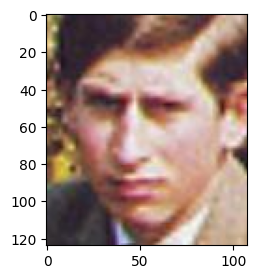

In [24]:
show_img(f'data/family/dad/{photo}')